In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "/Users/user/git/datasci")
from sci.metrics import rmse_score
from plots import *
import sci.features as scif
import sci.learn as sci
import sci.plots as scip


import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x)) #Limiting floats output to
pd.options.display.max_rows = 999

import numpy as np

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')


/Users/user/miniconda3/envs/test2/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


## Load Data

In [7]:
# raw data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [8]:
df_train = df_train.set_index("id")
df_test = df_test.set_index("id")

y = df_train["target"]
X = df_train.drop('target', axis=1)

print(y.shape)
print(df_train.shape)
print(X.shape)
print(df_test.shape)

(250,)
(250, 301)
(250, 300)
(19750, 300)


## Clean Data Types

In [4]:
# columsn with more than one data type (excluding NaN values)
display(scif.types_of_df(df_train, more_than_one=True))
display(scif.types_of_df(df_test, more_than_one=True))

,types,n_types


,types,n_types


### check and reduce skewness

In [6]:
scif.skewness_check(df_train).head(10)

,Skew
270,0.4307
94,0.4060
164,0.3611
16,0.3087
124,0.2668
241,0.2644
252,0.2595
185,0.2574
45,0.2549
136,0.2532


In [258]:
# scif.skewness_fix(df_train_proc)

In [7]:
# scif.skewness_check(df_train).head(10)

## Categorical Features
- text features with few values are classic categorical features
- text features with rich content are NOT
- numeric (integer) features with few values that represent categories can be treated as categorical, but can also be processed as numeric and let the model figure it out

What do we do with them?
- we can convert them to integers using LabelEncoder and let the model figure it out
- we can convert them to one-hot features using get_dummie or OneHotEncoder

TODO:  
solved with (drop_first=True) ?  
https://www.algosome.com/articles/dummy-variable-trap-regression.html

## Drop Outliers

In [9]:
from sklearn.linear_model import *

model = RidgeCV()
model.fit(X, y)
# from sklearn.model_selection import cross_val_score
# cross_val_score(model, X, y, scoring=rmse_score).mean()

y_pred = pd.Series(model.predict(X), index=y.index)
y_resid = y - y_pred
resid_mean = y_resid.mean()
resid_std  = y_resid.std()
resid_z = (y_resid - resid_mean) / resid_std
outliers_idx = y.index[np.abs(resid_z) >= 3]

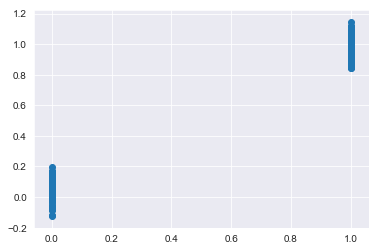

In [10]:
plt.scatter(y, y_pred)
plt.scatter(y.loc[outliers_idx], y_pred.loc[outliers_idx])

In [10]:
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

[autoreload of sci.learn failed: Traceback (most recent call last):
  File "/Users/user/miniconda3/envs/test2/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/Users/user/miniconda3/envs/test2/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
    module = reload(module)
  File "/Users/user/miniconda3/envs/test2/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Users/user/miniconda3/envs/test2/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/user/git/datasci/sci/learn.py", line 11, in <module>
    import sci.utils as sciu
AttributeError: module 'sci' has no attr

standard: 0.16 sec
ltsa: 0.19 sec
hessian: 0.36 sec
modified: 0.25 sec
Isomap: 0.35 sec
MDS: 1.1 sec
SpectralEmbedding: 0.062 sec
t-SNE: 6.2 sec


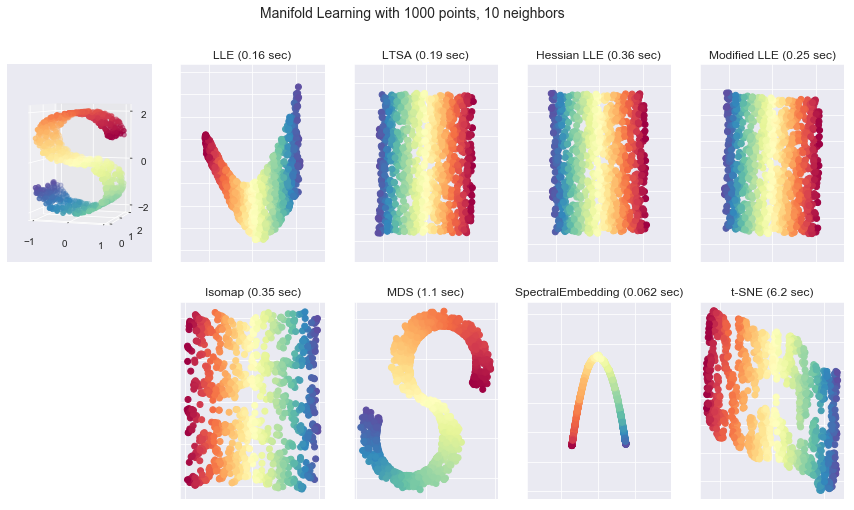

In [16]:
# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)


ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

In [101]:
n_components = 10
n_neighbors = 10

transformers = []

transformers.append(manifold.SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors))
# transformers.append(manifold.TSNE(n_components=n_components, init='pca', random_state=0))
transformers.append(manifold.MDS(n_components, max_iter=100, n_init=1))
transformers.append(manifold.Isomap(n_neighbors, n_components))

# methods = ['standard', 'ltsa', 'hessian', 'modified']
methods = ['standard', 'ltsa', 'modified']
methods = ['standard', 'modified']
for i, method in enumerate(methods):
    transformers.append(manifold.LocallyLinearEmbedding(n_neighbors, n_components, eigen_solver='auto', method=method))
    
res = [tr.fit_transform(X) for tr in transformers]
X_proc = np.column_stack(res)


/Users/user/miniconda3/envs/test2/lib/python3.6/site-packages/sklearn/manifold/locally_linear.py:450: RuntimeWarning: invalid value encountered in double_scalars
  alpha_i = np.linalg.norm(Vi.sum(0)) / np.sqrt(s_i)


In [92]:
X_proc.shape

(250, 25)

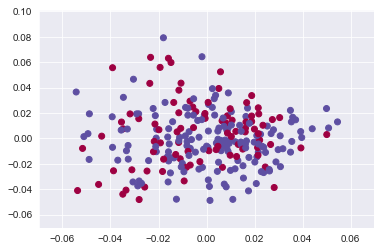

In [43]:
# plt.scatter(X_proc[:, 1], X_proc[:, 2], c=y, cmap=plt.cm.Spectral)

In [93]:
X_proc = pd.DataFrame(X_proc, index=X.index)

In [94]:
# df_train_proc = df_train_proc.drop(outliers_idx)

## Finished

In [95]:
scif.df_comp(X, df_test, "train", "test")


has NaN mismatch train vs test:

has NaN mismatch test vs train:

dtype mismatch:

unique categorical values mismatch in train:

unique categorical values mismatch in test:


## Split data

In [96]:
# X_train = df_train_proc.set_index("Id")
# y = X_train['SalePrice']
# X_train = X_train.drop('SalePrice', axis=1)

# X_score = df_test_proc.set_index("Id")

# print(X_train.shape, y.shape, X_score.shape)

## Save

In [97]:
path = 'processed_manifold'
!mkdir -p $path
X_proc.to_msgpack(f'{path}/X.msgpack')
y.to_msgpack(f'{path}/y.msgpack')
df_test.to_msgpack(f'{path}/X_score.msgpack')

# from sklearn.externals import joblib
# joblib.dump(y_tr, f'{path}/y_tr.joblib')


## Quick Test

In [98]:
import sklearn.utils
from sklearn.linear_model import *
import sci
from sklearn.metrics import roc_auc_score, make_scorer

In [100]:
import xgboost
from sklearn.svm import SVC, LinearSVC, NuSVC

# model = ElasticNetCV(l1_ratio=0.5)
model = xgboost.XGBClassifier()
model = SVC(kernel="linear", C=0.025, probability=True)

sci.metric_global = roc_auc_score
sci.scoring_global = make_scorer(sci.metric_global, needs_proba=True)

data = sci.load_data(path)
cv_scores = sci.score_cv(data, model, scoring=sci.scoring_global, verbose=2, cv=10)

(250, 25) (250,)
CV for XGBClassifier ..


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=11)]: Done  10 out of  10 | elapsed:    0.2s finished


,mean,std
XGBClassifier,0.5451,0.0440


Can't plot with only a single or no samples


In [85]:
X_proc.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
dtype: int64